In [1]:
#Imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime, timedelta
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:


# # Try different encodings (e.g., 'utf-8', 'latin-1', 'ISO-8859-1') until you find the correct one
# encodings = ['utf-8', 'latin-1', 'ISO-8859-1']

# for encoding in encodings:
#     try:
#         df_raw = pd.read_csv('ProfEngrsLandSurvyrsGeologist_Data.csv', encoding=encoding)
#         print(f"File read successfully with encoding: {encoding}")
#         break
#     except UnicodeDecodeError:
#         print(f"Error decoding with encoding: {encoding}. Trying the next one.")

# # If none of the encodings work, you might need to investigate the file and its actual encoding.


In [6]:
#Read in Data
df_raw_civil = pd.read_csv('civil_all_with_nonactive.csv', encoding= 'latin-1')
df_raw_ls = pd.read_csv('LS_all_with_nonactive.csv')

In [7]:
df_dual = (df_raw_civil.merge(df_raw_ls, on=["Org/Last Name","First Name", "Middle Name","Suffix"], how="inner",))
df_dual['Original Issue Date_x'] = df_dual['Original Issue Date_x'].astype('datetime64[ns]')
df_dual['Original Issue Date_y'] = df_dual['Original Issue Date_y'].astype('datetime64[ns]')
df_dual['Date_of_Dual'] = df_dual.apply(lambda row: max(row['Original Issue Date_x'], row['Original Issue Date_y']), axis=1)

In [61]:
# df_dual.to_csv("Duals_all_with_non_active.csv")

In [36]:
def plot_dual_licenses_per_year_against_other_licences(df_dual, df_compare, nameword, date_column='Original Issue Date', window=10):
    # Convert 'Original Issue Date' to datetime
    df_dual[date_column] = pd.to_datetime(df_dual['Date_of_Dual'], errors='coerce')

    # Extract the year from the 'Original Issue Date'
    df_dual['Year'] = df_dual['Date_of_Dual'].dt.year

    # Count the occurrences of each year
    dual_licenses_per_year = df_dual['Year'].value_counts().reset_index()
    dual_licenses_per_year.columns = ['Year', 'Number of Dual Licenses Issued']

    # Convert 'Original Issue Date' to datetime
    df_compare[date_column] = pd.to_datetime(df_compare[date_column], errors='coerce')

    # Extract the year from the 'Original Issue Date'
    df_compare['Year'] = df_compare[date_column].dt.year

    # Filter out years before 1980
    df_dual = df_dual[df_dual['Year'] >= 1942]
    df_compare = df_compare[df_compare['Year'] >= 1942]

    # Count the occurrences of each year
    compare_licenses_per_year = df_compare['Year'].value_counts().reset_index()
    compare_licenses_per_year.columns = ['Year', f'Number of {nameword}Licenses Issued']
    
    # Merge DataFrame
    merged_data = pd.merge(dual_licenses_per_year, compare_licenses_per_year, on='Year', how='left')
    
    # Create % per year column
    merged_data['Total percent'] = (merged_data['Number of Dual Licenses Issued'] / merged_data[f'Number of {nameword}Licenses Issued']) * 100
     # Handle zero values in percentage calculation
    merged_data['Total percent'] = merged_data.apply(
        lambda row: (row['Number of Dual Licenses Issued'] / row[f'Number of {nameword}Licenses Issued']) * 100 
        if row[f'Number of {nameword}Licenses Issued'] != 0 else 0, 
        axis=1
    )
    # Drop unused columns
    # merged_data = merged_data.drop(columns=['Number of Dual Licenses Issued', f'Number of {nameword}Licenses Issued'])

    # Sort the DataFrame by year
    merged_data = merged_data.sort_values(by='Year').reset_index(drop=True)

    # Calculate the moving average
    merged_data['Moving Average'] = merged_data['Total percent'].rolling(window=window, min_periods=1).mean()

    # Plot the data
    plt.plot(merged_data['Year'], merged_data['Total percent'], marker='o', label='Total percent')
    plt.plot(merged_data['Year'], merged_data['Moving Average'], 'r--', label=f'Moving Average ({window}-period)')

    plt.title(f'Percent of Dual Licenses Issued Each Year compared to {nameword}')
    plt.xlabel('Year')
    plt.ylabel(f'% Dual Licenses Issued compared with {nameword}')
    plt.legend()
    plt.grid(True)
    plt.show()

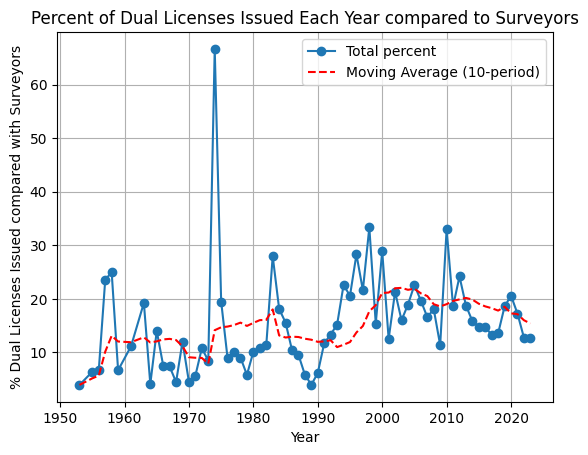

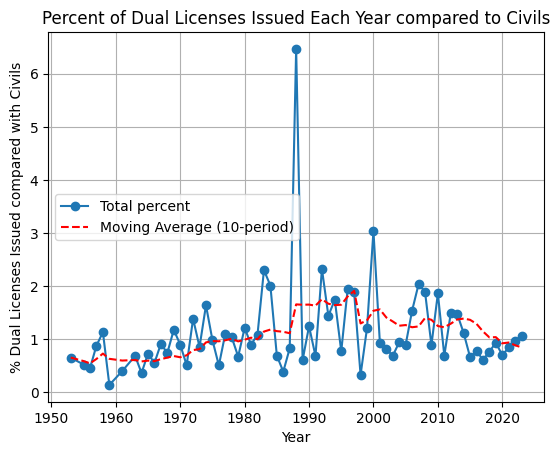

In [37]:
plot_dual_licenses_per_year_against_other_licences(df_dual, df_raw_ls, "Surveyors")
plot_dual_licenses_per_year_against_other_licences(df_dual, df_raw_civil, "Civils")

In [38]:
def plot_licenses_per_year_with_moving_average(df, nameword, title, yaxis_name, date_column='Original Issue Date', window=10):
    # Convert 'Original Issue Date' to datetime
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    # df.to_csv("test222.csv")
    # Extract the year from the 'Original Issue Date'
    df['Year'] = df[date_column].dt.year

    # Get the current year and set the end year to the end of the last year
    current_year = datetime.now().year
    end_year = current_year - 1

    # Filter the DataFrame to include only data up to the end of the last year
    df = df[df['Year'] <= end_year]

    # Count the occurrences of each year
    licenses_per_year = df['Year'].value_counts().reset_index()
    licenses_per_year.columns = ['Year', 'Number of Licenses Issued']

    # Sort the DataFrame by year
    licenses_per_year = licenses_per_year.sort_values(by='Year').reset_index(drop=True)

    # Calculate the moving average
    licenses_per_year['Moving Average'] = licenses_per_year['Number of Licenses Issued'].rolling(window=window, min_periods=1).mean()

    # Plot the data
    plt.plot(licenses_per_year['Year'], licenses_per_year['Number of Licenses Issued'], marker='o', label='Number of Licenses Issued')
    plt.plot(licenses_per_year['Year'], licenses_per_year['Moving Average'], 'r--', label=f'Moving Average ({window}-period)')

    plt.title(f'{title}')
    plt.xlabel('Year')
    plt.ylabel(f'{yaxis_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

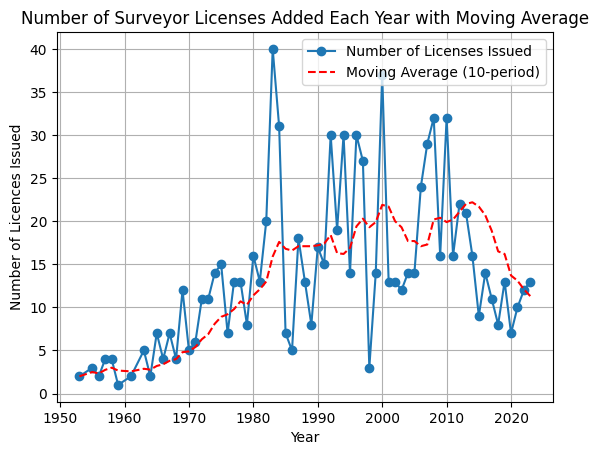

In [39]:
plot_licenses_per_year_with_moving_average(df_dual, "Dual Licences", 'Number of Surveyor Licenses Added Each Year with Moving Average', "Number of Licences Issued", date_column='Date_of_Dual')

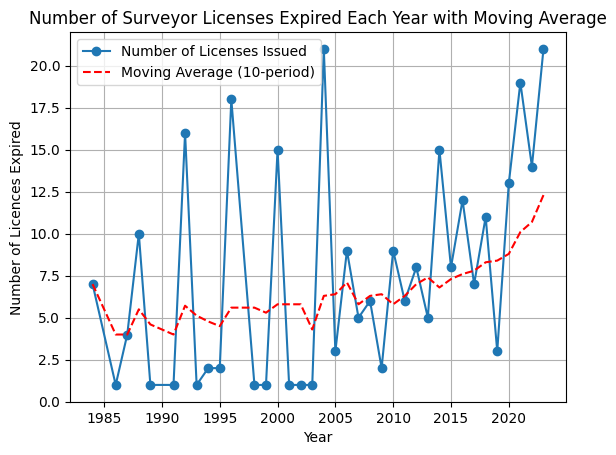

In [33]:
plot_licenses_per_year_with_moving_average(df_dual, "Dual Licences", 'Number of Surveyor Licenses Expired Each Year with Moving Average', "Number of Licences Expired",  date_column='Expiration Date_y')

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_active_licenses_with_moving_average(df, nameword, issue_date_column, expiration_date_column, start_licenses, expire_years, window=10):
    # Convert date columns to datetime
    df[issue_date_column] = pd.to_datetime(df[issue_date_column], errors='coerce')
    df[expiration_date_column] = pd.to_datetime(df[expiration_date_column], errors='coerce')
    # df.to_csv("test222.csv")
    # Get the current year and set the end year to the end of the last year
    current_year = datetime.now().year
    end_year = current_year - 1

    # Create a range of years from the earliest issue date to the end of last year
    start_year = int(df[issue_date_column].dt.year.min())
    years = range(start_year, end_year + 1)  # +1 to include end_year in the range


    # Determine the yearly decrease in licenses
    yearly_decrease = start_licenses / expire_years

    # Function to count active licenses for a given year
    def count_active_licenses(year):
        initial_licenses = max(start_licenses - (year - start_year) * yearly_decrease, 0)
        issued_after_start = len(df[(df[issue_date_column].dt.year <= year) & (df[expiration_date_column].dt.year > year)])
        return initial_licenses + issued_after_start

    # Calculate active licenses for each year
    active_per_year = [count_active_licenses(year) for year in years]

    # Create DataFrame for plotting
    plot_data = pd.DataFrame({'Year': years, 'Active Licenses': active_per_year})

    # Calculate the moving average
    plot_data['Moving Average'] = plot_data['Active Licenses'].rolling(window=window, min_periods=1).mean()

    # Plot the data
    plt.plot(plot_data['Year'], plot_data['Active Licenses'], marker='o', label='Active Licenses')
    plt.plot(plot_data['Year'], plot_data['Moving Average'], 'r--', label=f'Moving Average ({window}-period)')

    plt.title(f'Number of Active {nameword} Licenses Each Year with Moving Average (Up to {end_year})')
    plt.xlabel('Year')
    plt.ylabel('Number of Active Licenses')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# plot_active_licenses_with_moving_average(df, 'Surveyor', 'Original Issue Date', 'Expiration Date', start_licenses=1000, expire_years=10)


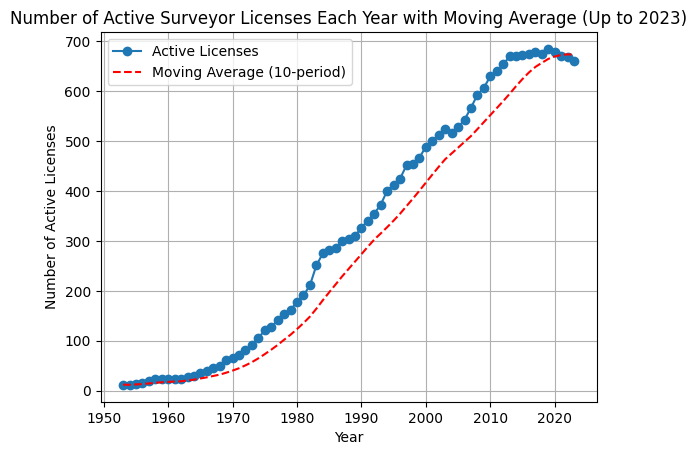

In [40]:
plot_active_licenses_with_moving_average(df_dual, "Surveyor", 'Date_of_Dual', 'Expiration Date_y', start_licenses=10, expire_years=20)

In [41]:
names = ['REVOKED', 'VOLUNTARY SURRENDER OF LICENSE', 'DENIED']  # Replace 'Name1', 'Name2', 'Name3' with the actual names you want to filter by
df_raw_ls_bad_apples = df_dual[df_dual['License Status_y'].isin(names)]

C:\Users\James\AppData\Local\Temp\ipykernel_60976\483072183.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
C:\Users\James\AppData\Local\Temp\ipykernel_60976\483072183.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df[date_column].dt.year


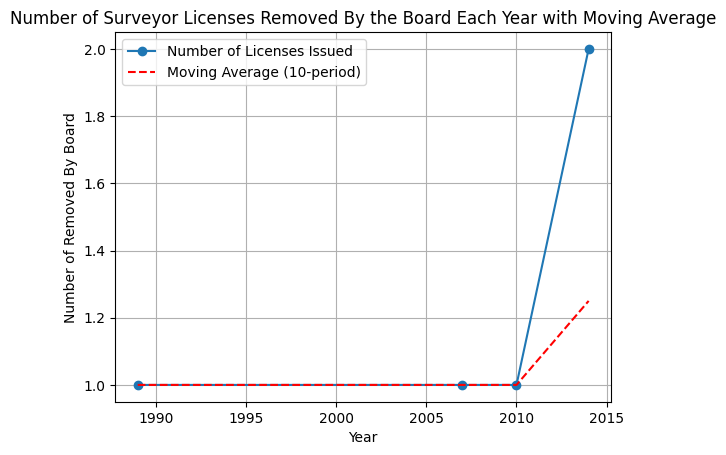

In [42]:
plot_licenses_per_year_with_moving_average(df_raw_ls_bad_apples, "Dual", 'Number of Dual Licenses Removed By the Board Each Year with Moving Average', "Number of Removed By Board",  date_column='Expiration Date_x')

In [43]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def plot_active_licenses_with_projection_and_projected_table(df, nameword, issue_date_column, expiration_date_column, window=10, projection_years=10, degree=3):
    # Convert date columns to datetime
    df[issue_date_column] = pd.to_datetime(df[issue_date_column], errors='coerce')
    df[expiration_date_column] = pd.to_datetime(df[expiration_date_column], errors='coerce')
    df.to_csv("test123.csv")
    # Define the range for historical data from 1982 onwards
    start_year = 1982
    current_year = datetime.now().year
    historical_end_year = current_year - 1
    projection_end_year = current_year + projection_years
    historical_years = range(start_year, historical_end_year + 1)
    projection_years_range = range(current_year, projection_end_year + 1)

    # Function to count active licenses for a given year
    def count_active_licenses(year):
        return len(df[(df[issue_date_column].dt.year <= year) & (df[expiration_date_column].dt.year > year)])

    # Calculate active licenses for each year in the historical range
    active_per_year = [count_active_licenses(year) for year in historical_years]

    # Create DataFrame for historical data
    historical_data = pd.DataFrame({'Year': historical_years, 'Active Licenses': active_per_year})

    # Calculate the moving average for historical data
    historical_data['Moving Average'] = historical_data['Active Licenses'].rolling(window=window, min_periods=1).mean()

    # Fit a polynomial regression model to the moving average of historical data
    X = np.array(historical_years).reshape(-1, 1)
    y = historical_data['Moving Average'].values
    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)

    # Compute R² value
    r2_value = model.score(X_poly, y)

    # Calculate fitted values (trend line) for historical years
    fitted_values = model.predict(X_poly)
    historical_data['Fitted Trend Line'] = fitted_values

    # Calculate all errors
    historical_data['Error MA to Actual'] = np.abs(historical_data['Active Licenses'] - historical_data['Moving Average'])
    historical_data['Error Trend Line to Actual'] = np.abs(historical_data['Active Licenses'] - historical_data['Fitted Trend Line'])
    historical_data['Error MA to Trend Line'] = np.abs(historical_data['Moving Average'] - historical_data['Fitted Trend Line'])

    # Project the moving average for the next 10 years
    projection_X = np.array(list(projection_years_range)).reshape(-1, 1)
    projection_X_poly = polynomial_features.transform(projection_X)
    projection_Y = model.predict(projection_X_poly)

    # Combine historical and projection data for plotting and table
    all_years = list(historical_years) + list(projection_years_range)
    all_active_licenses = list(historical_data['Active Licenses']) + [np.nan] * len(projection_years_range)
    all_moving_averages = list(historical_data['Moving Average']) + [np.nan] * len(projection_years_range)
    all_fitted_values = list(fitted_values) + list(projection_Y)
    all_errors_ma = list(historical_data['Error MA to Actual']) + [np.nan] * len(projection_years_range)
    all_errors_trend = list(historical_data['Error Trend Line to Actual']) + [np.nan] * len(projection_years_range)
    all_errors_ma_to_trend = list(historical_data['Error MA to Trend Line']) + [np.nan] * len(projection_years_range)

    combined_data = pd.DataFrame({
        'Year': all_years,
        'Active Licenses': all_active_licenses,
        'Moving Average': all_moving_averages,
        'Fitted Trend Line/Projection': all_fitted_values,
        'Error MA to Actual': all_errors_ma,
        'Error Trend Line to Actual': all_errors_trend,
        'Error MA to Trend Line': all_errors_ma_to_trend
    })

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot for historical and projected data
    ax.plot(combined_data['Year'], combined_data['Active Licenses'], marker='o', label='Active Licenses')
    ax.plot(combined_data['Year'], combined_data['Moving Average'], 'r--', label='Historical Moving Average')
    ax.plot(combined_data['Year'], combined_data['Fitted Trend Line/Projection'], 'g--', label='Fitted Trend Line / Projected Moving Average')
    ax.axvline(x=current_year, color='gray', linestyle=':', label='Start of Projection')
    ax.set_title(f'Number of Active {nameword} Licenses from 1982 Onwards with Projection')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Active Licenses')
    ax.legend()
    ax.grid(True)

    # Displaying the data table from 1982 onwards, including projections
    plt.figure(figsize=(15, 8))
    table_data = combined_data[combined_data['Year'] >= 1982].round(2)
    table = plt.table(cellText=table_data.values, colLabels=table_data.columns, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.axis('off')

    plt.show()

    return r2_value

# This function now includes the error between the Moving Average and the Fitted Trend Line, giving a more nuanced view of the model's performance over time.


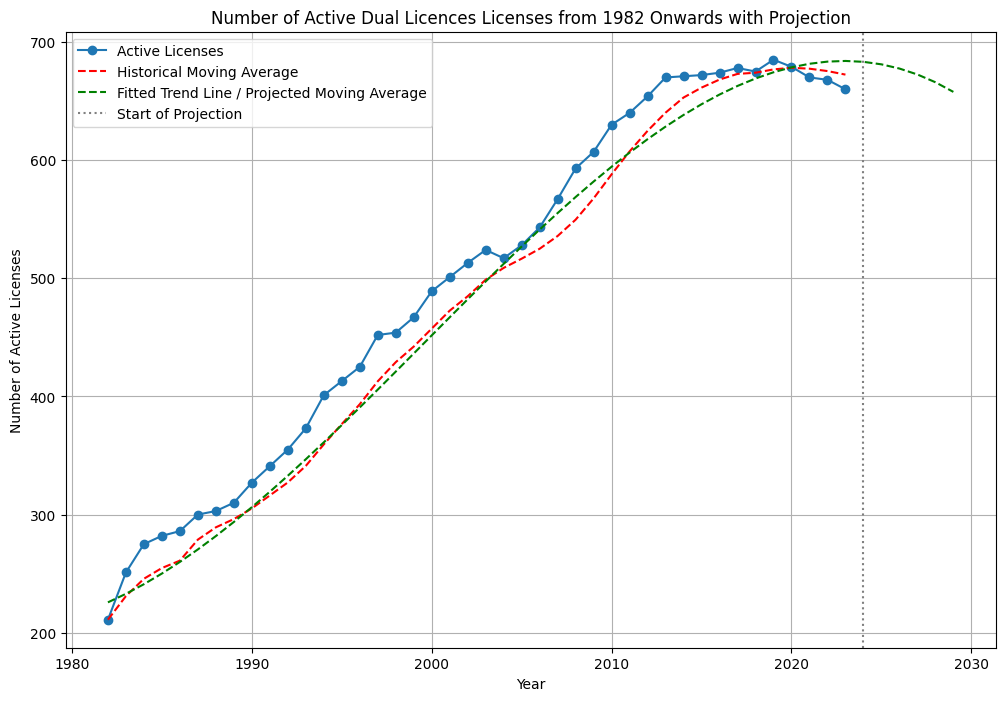

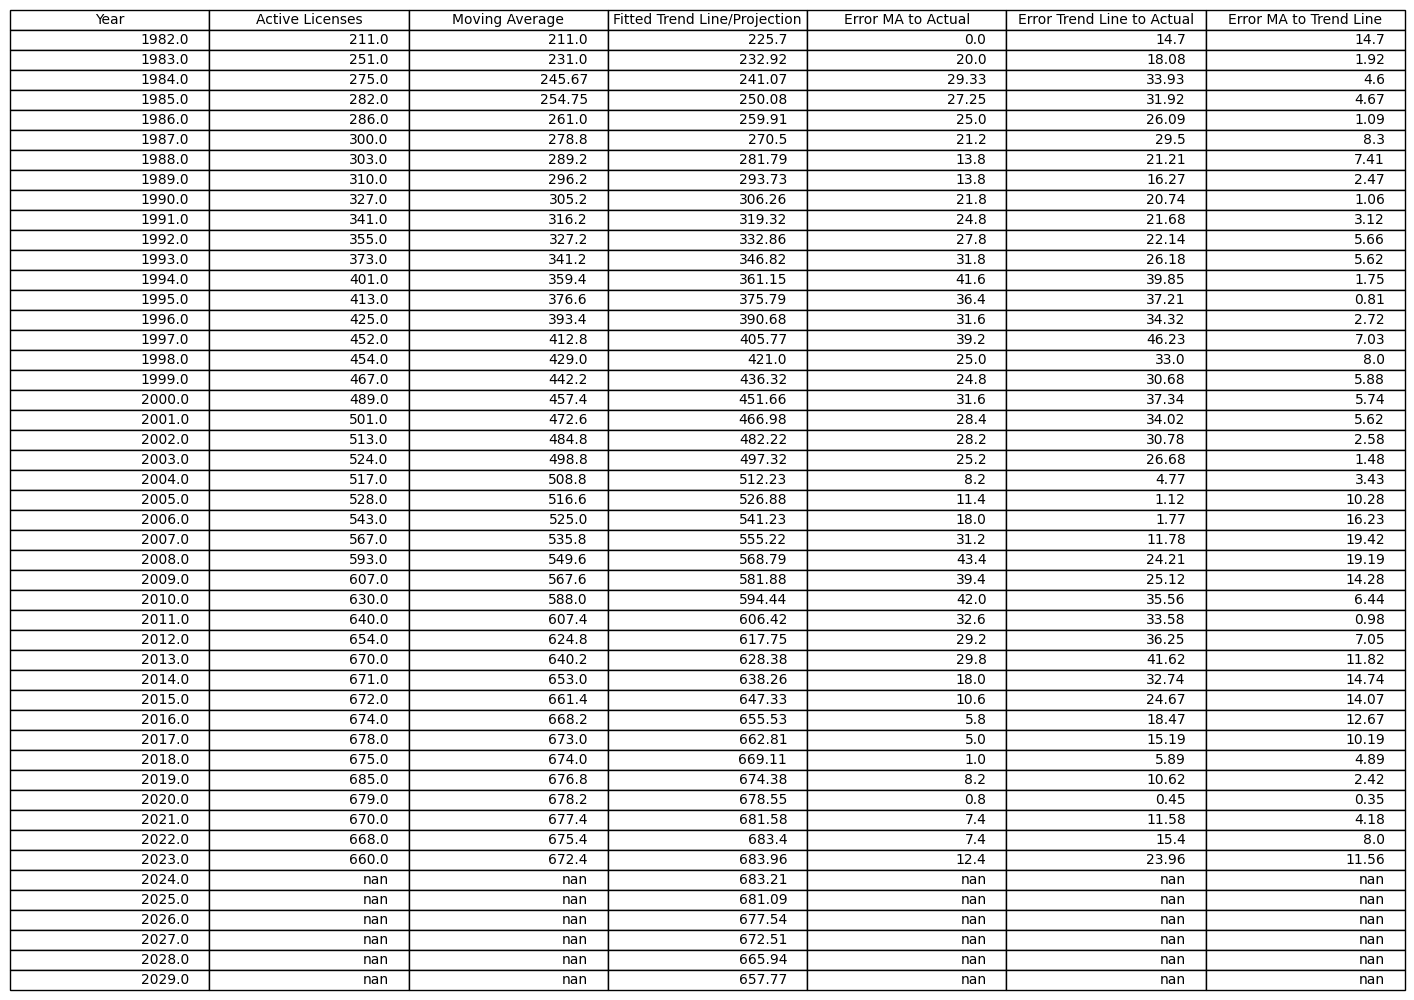

0.9968140043085435

In [47]:
plot_active_licenses_with_projection_and_projected_table(df_dual, "Dual Licences", 'Date_of_Dual', 'Expiration Date_y', window=5, projection_years=5, degree=3)

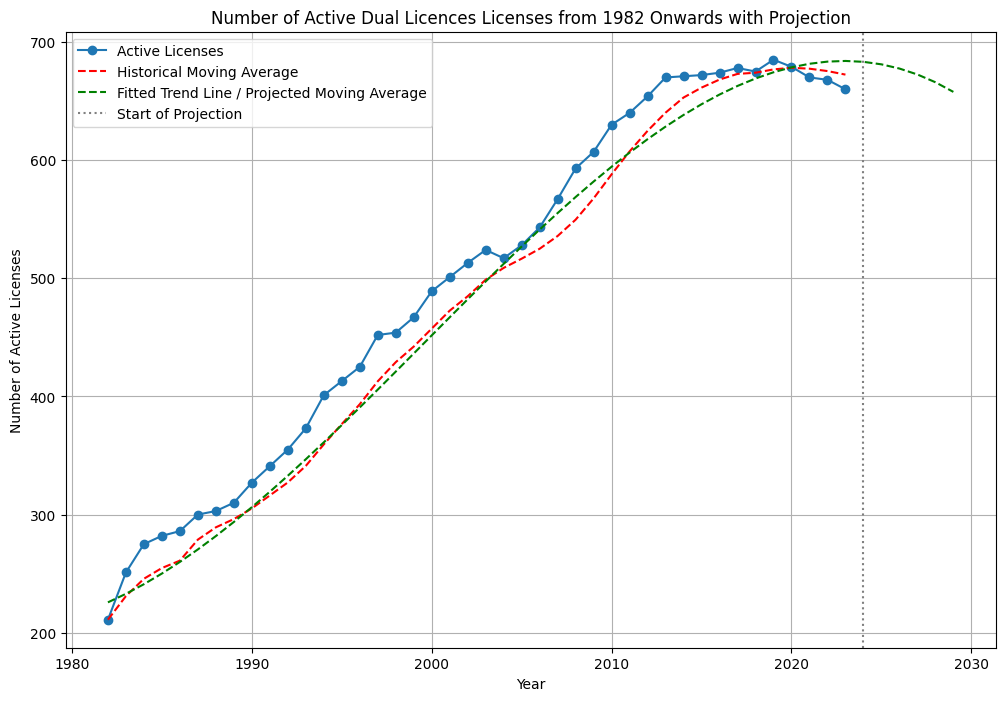

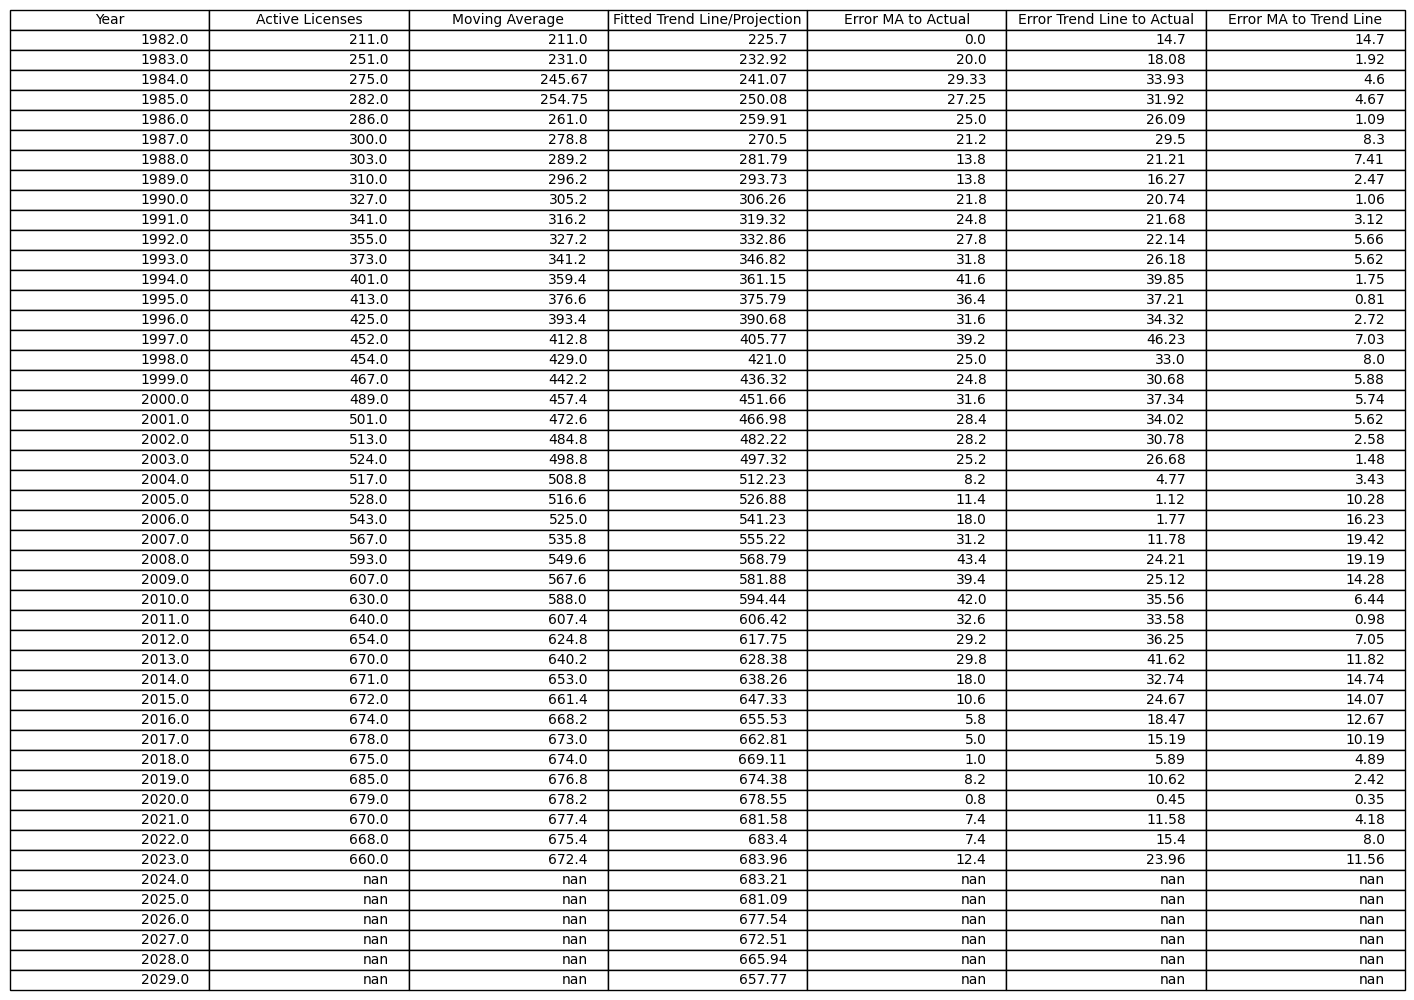

0.9968140043085435

In [48]:
plot_active_licenses_with_projection_and_projected_table(df_dual, "Dual Licences", 'Date_of_Dual', 'Expiration Date_y', window=10, projection_years=10, degree=3)

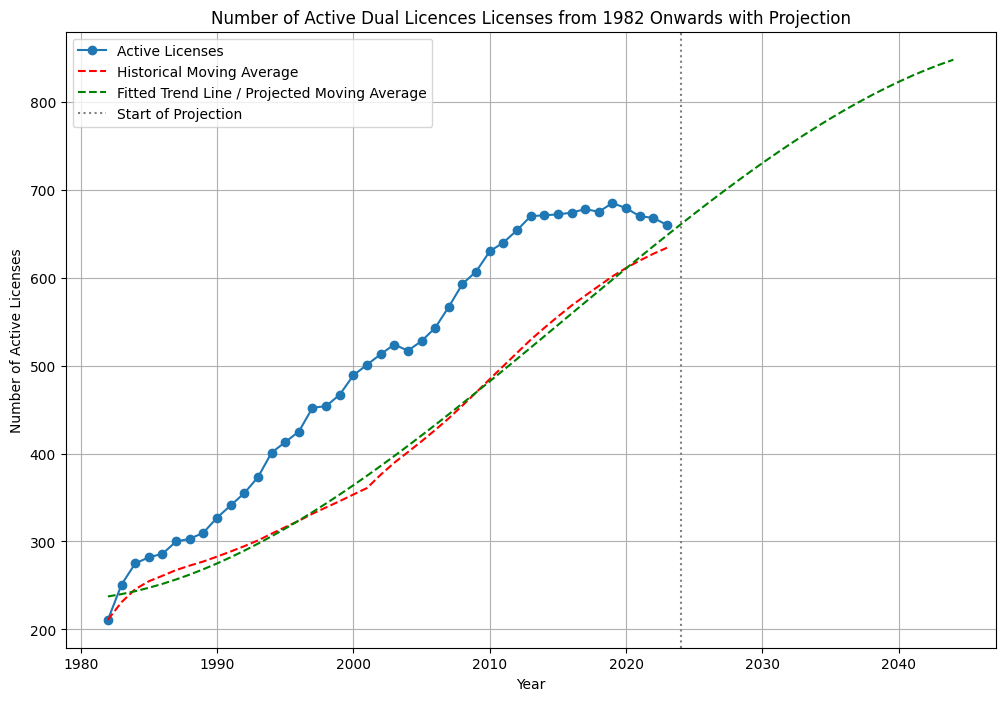

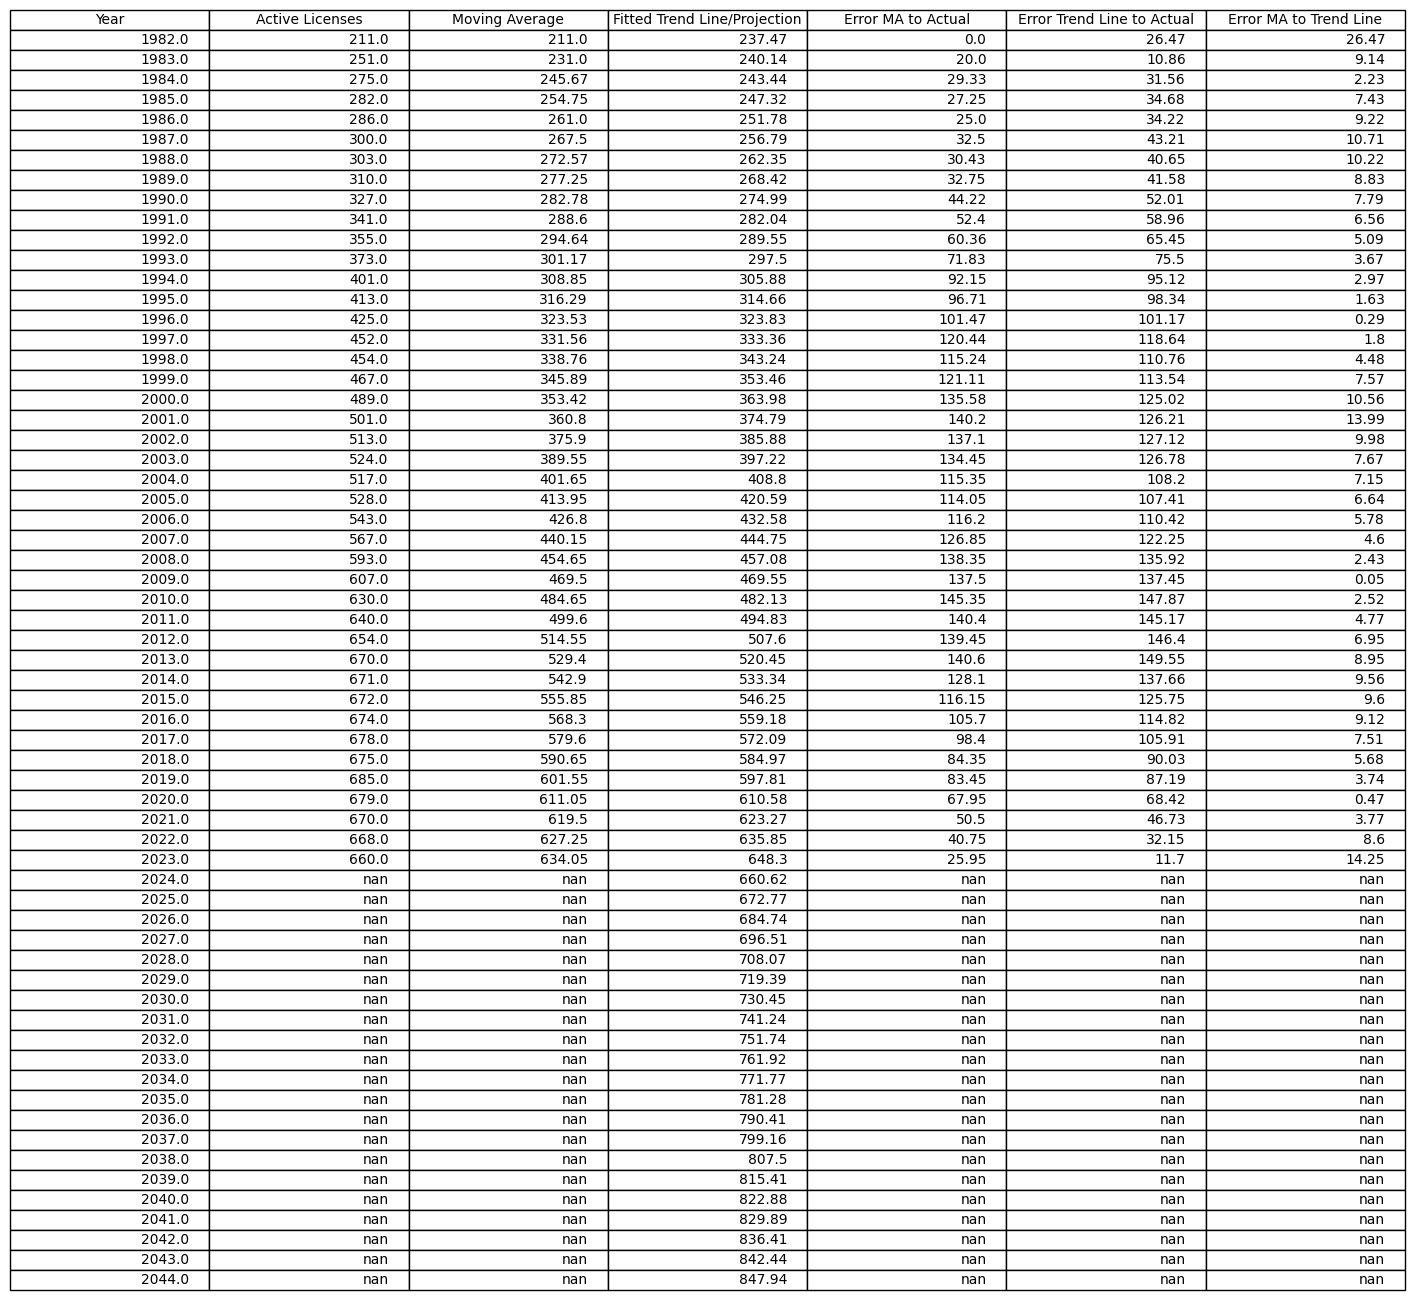

0.995832469085826

In [49]:
plot_active_licenses_with_projection_and_projected_table(df_dual, "Dual Licences", 'Date_of_Dual', 'Expiration Date_y', window=20, projection_years=20, degree=3)

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def plot_license_distribution_with_details(df, issue_date_col, license_type_col, selected_license_type, num_categories):
    # Convert issue date column to datetime
    df[issue_date_col] = pd.to_datetime(df[issue_date_col], errors='coerce')

    # Filter data by selected license type
    df_filtered = df[df[license_type_col] == selected_license_type]

    # Calculate the age of each license from today
    df_filtered['License Age'] = datetime.now().year - df_filtered[issue_date_col].dt.year

    # Count licenses over 30 years of age
    licenses_over_30 = df_filtered[df_filtered['License Age'] > 30].shape[0]

    # Determine the range of license ages
    min_age = df_filtered['License Age'].min()
    max_age = df_filtered['License Age'].max()

    # Create age ranges for the categories
    age_ranges = np.linspace(min_age, max_age, num_categories + 1)

    # Categorize each license into an age group
    df_filtered['Age Group'] = pd.cut(df_filtered['License Age'], bins=age_ranges, include_lowest=True, right=False)

    # Group by age group, calculate count and get date range
    grouped = df_filtered.groupby('Age Group')
    age_distribution = grouped.size()
    date_ranges = grouped[issue_date_col].agg(['min', 'max'])

    # Merge count and date range data
    table_data = pd.DataFrame({
        'Age Group': age_distribution.index.categories,
        'Number of Licenses': age_distribution.values,
        'Issuance Date Range': date_ranges.apply(lambda x: f"{x['min'].date()} - {x['max'].date()}", axis=1)
    }).reset_index(drop=True)

    # Plotting bar chart and table
    fig, ax = plt.subplots(figsize=(18, 12))
    age_distribution.plot(kind='bar', ax=ax)
    ax.set_xlabel('License Age Groups (Years from Today)')
    ax.set_ylabel('Number of Licenses')
    ax.set_title(f'Distribution of {selected_license_type} Licenses by Age as of {datetime.now().date()}')
    ax.grid(True)

    # Annotate the total number of licenses over 30 years
    plt.text(0.95, 0.95, f'Number of licenses near retirement age (over 30 years of licensure): {licenses_over_30}',
             horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=10, color='red')

    # Creating table with actual values
    table = plt.table(cellText=table_data.values, colLabels=table_data.columns, loc='right', cellLoc='center')

    # Adjust layout to make room for table
    plt.subplots_adjust(right=0.7)
    plt.show()

# Example usage:
# plot_license_distribution_with_details(your_dataframe, 'issue_date_column_name', 'license_type_column_name', 'specific_license_type', num_categories=10)


C:\Users\James\AppData\Local\Temp\ipykernel_60976\3522482896.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['License Age'] = datetime.now().year - df_filtered[issue_date_col].dt.year
C:\Users\James\AppData\Local\Temp\ipykernel_60976\3522482896.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Age Group'] = pd.cut(df_filtered['License Age'], bins=age_ranges, include_lowest=True, right=False)


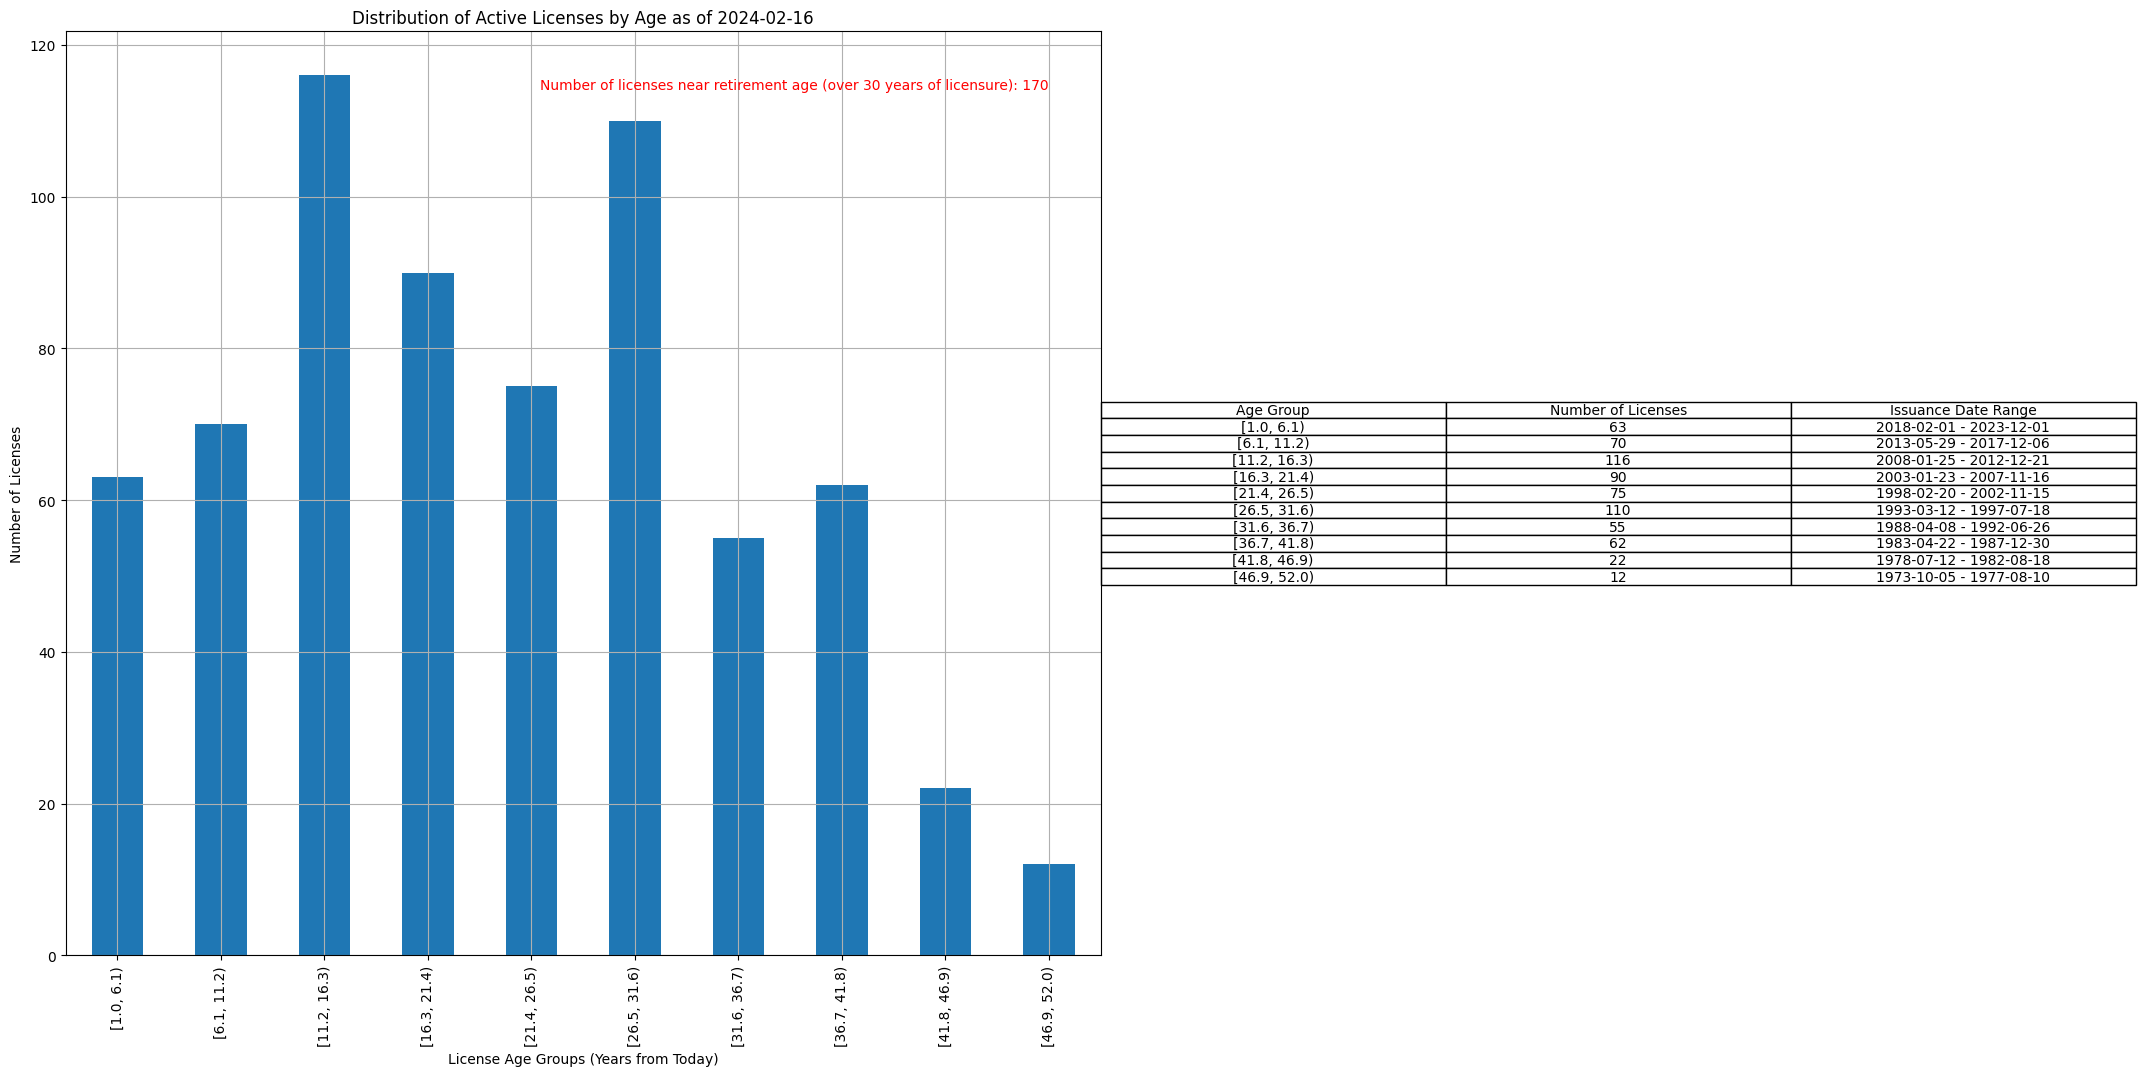

In [54]:
plot_license_distribution_with_details(df_dual, 'Date_of_Dual', 'License Status_x', 'Active', num_categories=10)


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.ticker as ticker

def plot_out_of_state_licenses_line_chart(df, issue_date_col, state_status_col, out_of_state_indicators):
    # Convert issue date column to datetime
    df[issue_date_col] = pd.to_datetime(df[issue_date_col], errors='coerce')

    # Filter out-of-state licenses
    out_of_state_df = df[df[state_status_col].isin(out_of_state_indicators)]

    # Extract year from issue date
    out_of_state_df['Issue Year'] = out_of_state_df[issue_date_col].dt.year

    # Count the number of out-of-state licenses issued each year
    yearly_distribution = out_of_state_df['Issue Year'].value_counts().sort_index()

    # Plotting line chart
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(yearly_distribution.index, yearly_distribution.values, marker='o', linestyle='-')

    # Formatting the plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Out-of-State Licenses')
    ax.set_title('Number of Out-of-State Licenses Issued Each Year')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # # Adding table with actual values
    # table_data = yearly_distribution.reset_index()
    # table_data.columns = ['Year', 'Licenses']
    # table = plt.table(cellText=table_data.values, colLabels=table_data.columns, loc='right', cellLoc='center')

    # Adjust layout to make room for table
    plt.subplots_adjust(right=0.7)
    plt.show()

# Example usage:
# plot_out_of_state_licenses_line_chart(your_dataframe, 'issue_date_column_name', 'state_status_column_name', out_of_state_indicators_list)


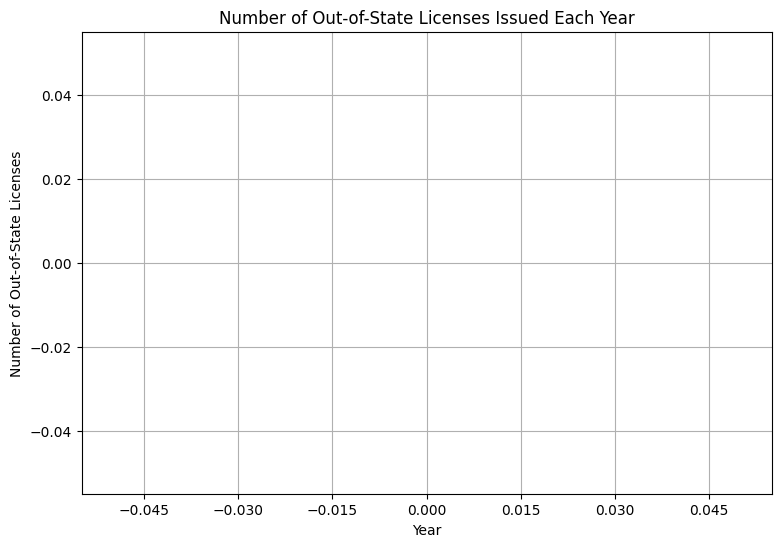

In [62]:

# Define new categories to be added
new_categories1 = ['out_of_state', 'OUT OF STATE', 'OUT OF COUNTRY']

plot_out_of_state_licenses_line_chart(df_dual, 'Date_of_Dual', 'County_y', out_of_state_indicators=new_categories1)

In [57]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

def plot_count_differences_with_moving_average(df, column1, column2, title, yaxis_name, window=10, ):
    # Convert 'column1' and 'column2' to datetime
    df[column1] = pd.to_datetime(df[column1], errors='coerce')
    df[column2] = pd.to_datetime(df[column2], errors='coerce')

    # Extract the year from 'column1' and 'column2' for grouping
    df['Year1'] = df[column1].dt.year
    df['Year2'] = df[column2].dt.year

    # Group the data by year and count the occurrences in each column
    grouped1 = df.groupby('Year1').agg({column1: 'count'})
    grouped2 = df.groupby('Year2').agg({column2: 'count'})

    # Merge the two grouped dataframes on the year and fill missing values
    merged = pd.merge(grouped1, grouped2, left_index=True, right_index=True, how='outer').fillna(0)

    # Get the end of the last year
    end_of_last_year = datetime.now().year - 1

    # Filter the data to include only up to the end of the last year
    merged = merged[merged.index <= end_of_last_year]

    # Calculate the yearly difference
    merged['Yearly Difference'] = merged[column1] - merged[column2]

    # Calculate the moving average
    merged['Moving Average'] = merged['Yearly Difference'].rolling(window=window, min_periods=1).mean()

    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(merged.index, merged['Yearly Difference'], marker='o', label='Yearly Difference')
    plt.plot(merged.index, merged['Moving Average'], linestyle='--', color='red', label=f'{window}-Year Moving Average')

    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(yaxis_name)
    plt.legend()
    plt.grid(True)
    plt.show()


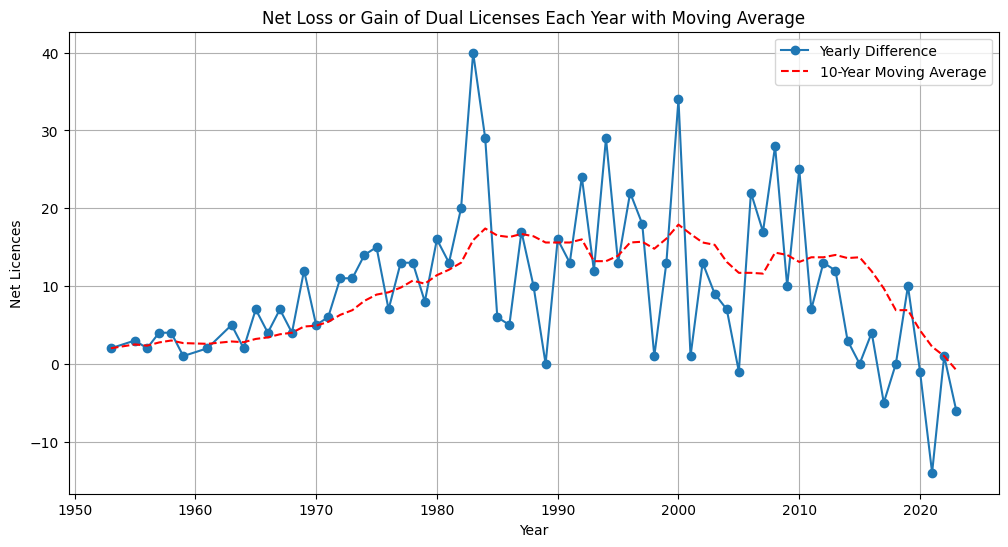

In [58]:
plot_count_differences_with_moving_average(df_dual,'Date_of_Dual', 'Expiration Date_x','Net Loss or Gain of Dual Licenses Each Year with Moving Average', 'Net Licences')

In [49]:
def plot_yearly_differences_with_projection(df, column1, column2, nameword, window=10, projection_years=10, degree=3):
    # Convert 'column1' and 'column2' to datetime and extract years
    df[column1] = pd.to_datetime(df[column1], errors='coerce').dt.year
    df[column2] = pd.to_datetime(df[column2], errors='coerce').dt.year

    # Group by year and count occurrences
    grouped1 = df.groupby(column1).size()
    grouped2 = df.groupby(column2).size()

    # Merge and calculate yearly differences
    yearly_data = pd.merge(grouped1, grouped2, left_index=True, right_index=True, how='outer').fillna(0)
    yearly_data['Yearly Difference'] = yearly_data[column1] - yearly_data[column2]

    # Calculate moving average
    yearly_data['Moving Average'] = yearly_data['Yearly Difference'].rolling(window=window, min_periods=1).mean()

    # Fit polynomial regression
    current_year = datetime.now().year
    historical_years = yearly_data.index
    X = np.array(historical_years).reshape(-1, 1)
    y = yearly_data['Moving Average'].values
    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)

    # Project future values
    projection_end_year = current_year + projection_years
    projection_years_range = range(current_year, projection_end_year + 1)
    projection_X = np.array(list(projection_years_range)).reshape(-1, 1)
    projection_X_poly = polynomial_features.transform(projection_X)
    projection_Y = model.predict(projection_X_poly)

    # Combine historical and projected values for plotting
    all_years = list(historical_years) + list(projection_years_range)
    all_fitted_values = list(model.predict(X_poly)) + list(projection_Y)
    combined_data = pd.DataFrame({'Year': all_years, 'Yearly Difference': yearly_data['Yearly Difference'], 
                                  'Moving Average': yearly_data['Moving Average'], 
                                  'Fitted Trend Line/Projection': all_fitted_values})

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data['Year'], combined_data['Yearly Difference'], marker='o', label='Yearly Difference')
    plt.plot(combined_data['Year'], combined_data['Moving Average'], linestyle='--', color='red', label='Moving Average')
    plt.plot(combined_data['Year'], combined_data['Fitted Trend Line/Projection'], linestyle='-', color='green', label='Fitted Trend Line / Projection')
    plt.axvline(x=current_year, color='gray', linestyle=':', label='Start of Projection')
    plt.title(f'{nameword} Yearly Differences with Historical Data and Polynomial Projection')
    plt.xlabel('Year')
    plt.ylabel('Yearly Difference')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return R² value of the model
    return model.score(X_poly, y)


In [50]:
# plot_yearly_differences_with_projection(df_raw_all_with_secondary,'Original Issue Date', 'Expiration Date','Surveyors', window=10, projection_years=10, degree=3)

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from datetime import datetime

def plot_net_gain_loss_of_surveyors_with_errors(df, nameword, issue_date_column, expiration_date_column, window=10, projection_years=10, degree=3):
    # Convert date columns to datetime
    df[issue_date_column] = pd.to_datetime(df[issue_date_column], errors='coerce')
    df[expiration_date_column] = pd.to_datetime(df[expiration_date_column], errors='coerce')

    # Define the range for historical data and future projection
    start_year = 1970
    current_year = datetime.now().year
    historical_end_year = current_year - 1
    projection_end_year = current_year + projection_years
    historical_years = range(start_year, historical_end_year + 1)
    projection_years_range = range(current_year, projection_end_year + 1)

    # Function to count issued and expired licenses for a given year
    def count_issued(year):
        return df[df[issue_date_column].dt.year == year].shape[0]

    def count_expired(year):
        return df[df[expiration_date_column].dt.year == year].shape[0]

    # Calculate issued and expired licenses for each year in the historical range
    net_gain_loss_per_year = {}
    for year in historical_years:
        issued = count_issued(year)
        expired = count_expired(year)
        net_gain_loss_per_year[year] = issued - expired

    # Create DataFrame for historical data
    historical_data = pd.DataFrame(list(net_gain_loss_per_year.items()), columns=['Year', 'Net Gain/Loss'])

    # Calculate the moving average for net gain/loss
    historical_data['Moving Average'] = historical_data['Net Gain/Loss'].rolling(window=window, min_periods=1).mean()

    # Fit a polynomial regression model to the moving average of net gain/loss
    X = historical_data['Year'].values.reshape(-1, 1)
    y = historical_data['Moving Average'].values
    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)

    # Compute R² value
    r2_value = model.score(X_poly, y)

    # Calculate fitted values (trend line) for historical years
    fitted_values = model.predict(X_poly)
    historical_data['Fitted Trend Line'] = fitted_values

    # Calculate errors
    historical_data['Error MA to Actual'] = np.abs(historical_data['Net Gain/Loss'] - historical_data['Moving Average'])
    historical_data['Error Trend Line to Actual'] = np.abs(historical_data['Net Gain/Loss'] - historical_data['Fitted Trend Line'])

    # Project the moving average for the next 10 years
    projection_X = np.array(list(projection_years_range)).reshape(-1, 1)
    projection_X_poly = polynomial_features.transform(projection_X)
    projection_Y = model.predict(projection_X_poly)

    # Ensure all arrays are of the same length
    all_years = list(historical_years) + list(projection_years_range)
    all_net_gain_loss = list(historical_data['Net Gain/Loss']) + [np.nan] * len(projection_years_range)
    all_moving_averages = list(historical_data['Moving Average']) + [np.nan] * len(projection_years_range)
    all_fitted_values = list(fitted_values) + list(projection_Y)
    all_errors_MA = list(historical_data['Error MA to Actual']) + [np.nan] * len(projection_years_range)
    all_errors_trend = list(historical_data['Error Trend Line to Actual']) + [np.nan] * len(projection_years_range)

    # Combine into a DataFrame
    combined_data = pd.DataFrame({
        'Year': all_years,
        'Net Gain/Loss': all_net_gain_loss,
        'Moving Average': all_moving_averages,
        'Fitted Trend Line/Projection': all_fitted_values,
        'Error MA to Actual': all_errors_MA,
        'Error Trend Line to Actual': all_errors_trend
    })

    # Plotting the Graph
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(combined_data['Year'], combined_data['Net Gain/Loss'], marker='o', label='Net Gain/Loss')
    ax.plot(combined_data['Year'], combined_data['Moving Average'], 'r--', label='Moving Average')
    ax.plot(combined_data['Year'], combined_data['Fitted Trend Line/Projection'], 'g--', label='Projected Trend')
    ax.axvline(x=current_year, color='gray', linestyle=':', label='Start of Projection')
    ax.set_title(f'Yearly Net Gain/Loss of {nameword} Licenses from {start_year} Onwards with Projection')
    ax.set_xlabel('Year')
    ax.set_ylabel('Net Gain/Loss')
    ax.legend()
    ax.grid(True)
    plt.show()

    # Plotting the Table
    fig, ax_table = plt.subplots(figsize=(12, 8))  # Adjust size as needed
    ax_table.axis('tight')
    ax_table.axis('off')
    table_data = combined_data.round(2)
    table = ax_table.table(cellText=table_data.values, colLabels=table_data.columns, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.show()

    return r2_value

# This function now includes error calculations and a better layout for the plot and table.


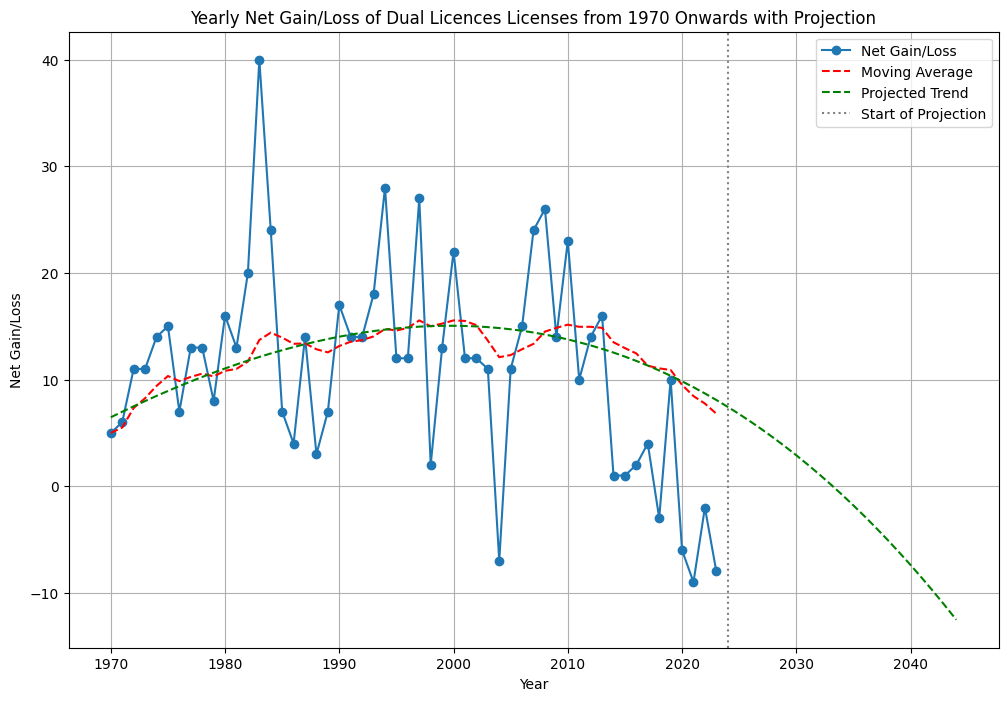

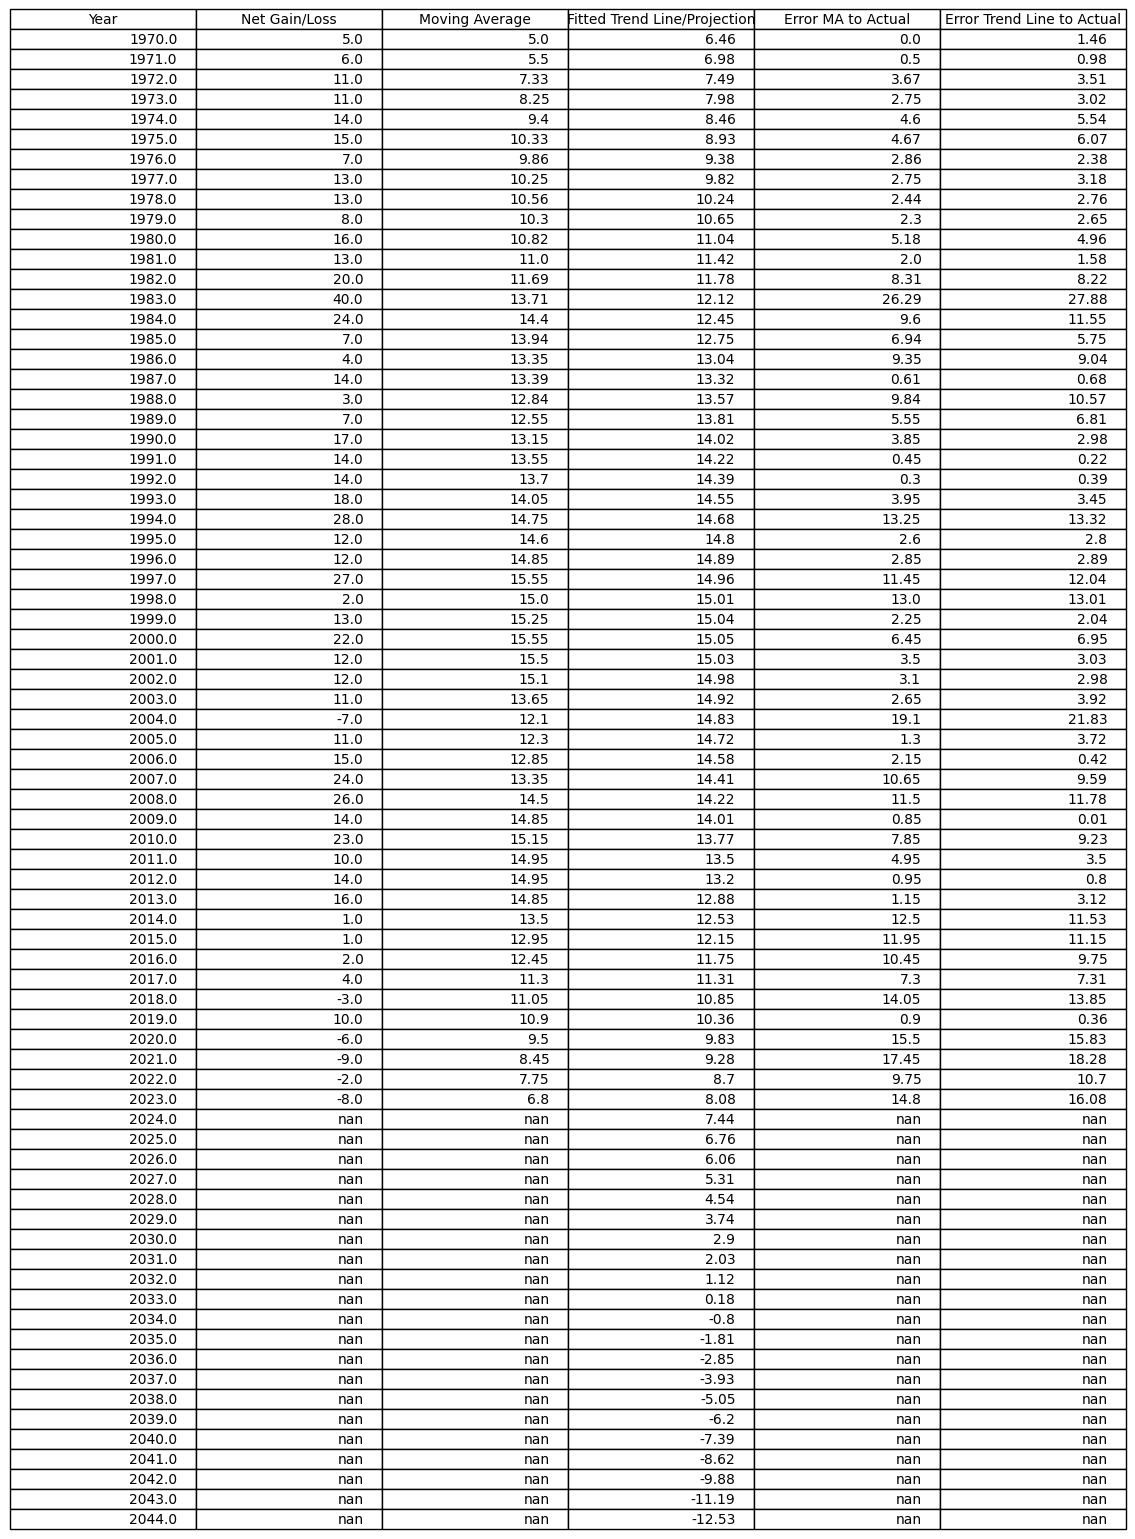

0.8525646345071367

In [60]:
plot_net_gain_loss_of_surveyors_with_errors(df_dual,'Dual Licences', 'Date_of_Dual', 'Expiration Date_y', window=20, projection_years=20, degree=3)